In [20]:
%load_ext autoreload
%autoreload 2
import pycolmap
from pathlib import Path
import shutil
import os
from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [29]:
orig_images = Path('datasets/rgbd_dataset_freiburg1_xyz/rgb/')
images=Path('init/')
outputs = Path('outputs/sfm/')
sfm_pairs = outputs / 'pairs-netvlad.txt'
sfm_dir = outputs / 'sfm_superpoint+superglue'

retrieval_conf = extract_features.confs['netvlad']
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']
if(os.path.isdir(images)):
    shutil.rmtree(images)
if(os.path.isdir(outputs)):
    shutil.rmtree(outputs)
os.mkdir(images)

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM.

In [3]:
if not images.exists():
    !wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P datasets/
    !unzip -q datasets/South-Building.zip -d datasets/

In [31]:
images_list = sorted(list(orig_images.iterdir()))[:50]
images_list=images_list[::10]
i=0
for image in images_list:
    shutil.copyfile(image,str(images)+'/'+os.path.basename(image))
    i=i+1

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [32]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2022/04/18 11:15:39 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2022/04/18 11:15:39 hloc INFO] Found 5 images in root init.
100%|██████████| 5/5 [00:11<00:00,  2.26s/it]
[2022/04/18 11:15:59 hloc INFO] Finished exporting features.
[2022/04/18 11:16:00 hloc INFO] Extracting image pairs from a retrieval database.
[2022/04/18 11:16:00 hloc INFO] Found 20 pairs.


## Extract and match local features

In [33]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

[2022/04/18 11:16:21 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/04/18 11:16:21 hloc INFO] Found 5 images in root init.


Loaded SuperPoint model


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]
[2022/04/18 11:16:27 hloc INFO] Finished exporting features.
[2022/04/18 11:16:27 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]
[2022/04/18 11:16:45 hloc INFO] Finished exporting matches.


## 3D reconstruction
Run COLMAP on the features and matches.

In [34]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2022/04/18 11:17:22 hloc INFO] Creating an empty database...
[2022/04/18 11:17:22 hloc INFO] Importing images into the database...
[2022/04/18 11:17:22 hloc INFO] Importing features into the database...
100%|██████████| 5/5 [00:00<00:00, 665.64it/s]
[2022/04/18 11:17:22 hloc INFO] Importing matches into the database...
100%|██████████| 20/20 [00:00<00:00, 941.51it/s]
[2022/04/18 11:17:22 hloc INFO] Performing geometric verification of the matches...
[2022/04/18 11:17:22 hloc INFO] Running 3D reconstruction...
[2022/04/18 11:17:24 hloc INFO] Reconstructed 1 model(s).
[2022/04/18 11:17:24 hloc INFO] Largest model is #0 with 5 images.
[2022/04/18 11:17:24 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 5
	num_cameras = 1
	num_points3D = 678
	num_observations = 3061
	mean_track_length = 4.51475
	mean_observations_per_image = 612.2
	mean_reprojection_error = 0.819353
	num_input_images = 5


## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

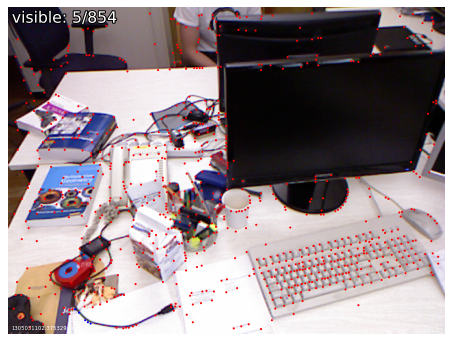

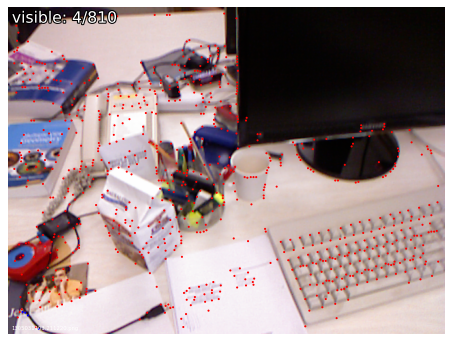

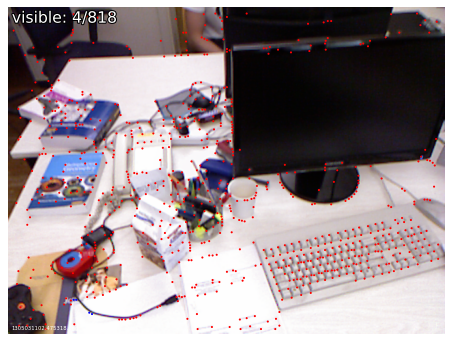

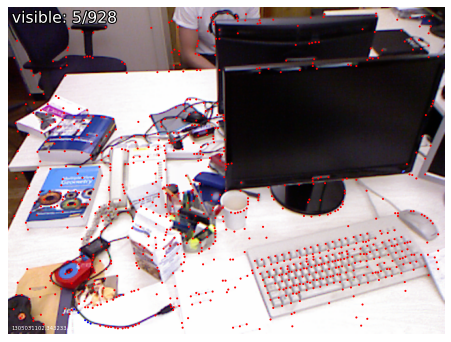

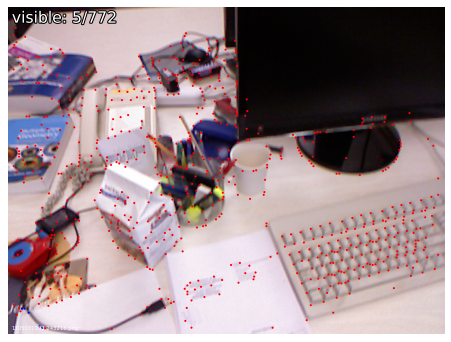

In [6]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=5)

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='track_length', n=5)

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='depth', n=5)

In [35]:
from hloc.utils import viz_3d
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()